# Ensemble Classifiers

### Introduction to Our Problem
There are literally tens of thousands of movies out there today. While some do great at the box office and bring in a lot of money, others flop making only a fraction compared to the top hits. What if we had a scientific way of accurately predicting how much revenue a movie would generate over its lifetime? Well, through machine learning we believe that we actually can!

The dataset we are using is found on <a href="https://www.kaggle.com/deepmatrix/imdb-5000-movie-dataset">Kaggle</a>. It consists of 5000+ movies scraped from the review site IMDB. There is quite a bit of data recorded for each movie and so we had a lot to work with to try to predict the next big hit. The data was collected from web scraping IMDB using a python library called "scrappy" to collect all of the data below. The features recorded for each movie are: 

Basic Info:
- movie title
- color (black and white or color)	
- duration of the movie
- director name
- gross (total revenue)
- genres (a lits of different genres ascribed to the movie)
- number of faces in movie poster
- language of the movie
- country the movie was produced in
- content rating (G, PG, PG-13, R, NC-17)
- budget
- year of release
- aspect ratio
- name of the 3rd actor
- name of the 2nd actor
- name of the 1st actor

Facebook Info:
- number of director facebook likes
- number of facebook likes for the whole cast
- number of the movie's facebook likes
- number of the 3rd actor's facebook likes
- number of the 2nd actor's facebook likes
- number of the 1st actor's facebook likes

IMDB Specific Info:
- number of imdb users who rated the movie
- number of critical reviews for the movie
- number of users who left a review
- imdb score
- top plot keywords


With all of this data collected on so many movies, we hope to be able to use this to build out a multi-layer perceptron  to accurately predict the financial success (measured in categories of gross revenue: low, low-mid, high-mid, and high) of a movie. We think that this could be a useful tool to anyone in the movie industry who is concerned with making a profit on their movie. It could also help a producer understand which of these features are the most important to an accurate prediction, what content rating is most important, how budget affects outcome, etc.


We believe that the algorithm would have to predict with a relatively low cost (under ~30) to be found useful by movie directors, producers, etc. 

### Data Pre-processing:
We made a number of changes to both the original csv obtained from kaggle before we loaded it and to the data once it was loaded in.


Pre-processing of the CSV:
- We first removed the imdb link from the csv because we knew we would never need to use that (**Note: this was the only feature removed from the csv**)
- We then went through and deleted all of the movies that were made in another country (foriegn films) we did this because we wanted to just look at American films, also because the currency units for those countries (for budget and gross) were in native currency units, not USD, and with changing exchange rates, it's not very easy to compare across countries.
- We then went through and converted all 0 values for gross, movie_facebook_likes, and director_facebook_likes to a blank value in the csv (so that it is read in as NaN by pandas), this is so that we cna more easily impute values later. Note: according to the description on the kaggle entry, because of the way the data was scraped, some movies had missing data. The Python scraper just made these values into a 0 instead of NaN.
- We then removed all movies with an undefined gross. Being the feature we are trying to predict, we should not be imputing values for gross to train our model. That will basically reduce our model to an imputation algorithm...
- We then removed all movies that were made before 1935. We did this because there were only a handful of movies ranging from 1915 to 1935, the way we are classifying budget (described below) would not work with a small sample of movies from that time period. We could have cut this number at a different year (say 1960), but we didn't want to exclude such classics as "Bambi" or "Gone With the Wind"
- Lastly, we had to adjust the gross revenue and budget values for inflation, since the movies spanned many years. For adjusting for inflation we obtained a csv of consumer price index (CPI) for every month since 1947. To simplify, we just took the value for January of that year to use for the whole year. We then took the CPI and calculated the ratio per year compared to 2017 dollars. We then took the budget and gross and multiplied them out with their appropriate ratio value. We then exported this to the csv that we use for the rest of this lab. **NB:** This was done outside of this notebook because this whole process took a very long time when it was included in the notebook when done every time.

Pre-processing of the Data:
- After the above steps, we made more edits to the data using pandas. First, we removed features that we thought would be un-useful to our prediction algorithm. We removed all features concerning facebook likes. We did this because a significant portion of the movies in the training set debuted before facebook was invented and widely adopted. While some of these movies have received retroactive "likes" on facebook, only the most famous classics received a substantial amount of retraoctive "likes". Most lesser known films received very low amounts of "likes" (presumably because modern movie watchers don't really care to search for lesser known movies on facebook, or because the movie doesn't have a facebook). For this reason we decided to remove movie_facebook_likes
- Likewise, we removed the other "likes" for the same reasons as above. For example, the esteemed director George Lucas has a total of 0 "likes" between all of his films. This feature obviously would not help us predict the profitability of movies.
- We also removed irrelevant information such as aspect_ratio, language, and country. Because we deleted all foreign films the country will always be USA. A simple filter of the data reveals that there are no more than 20 movies made in the US that use a language other than English, therefore there is not enough data to use language as training feature. However, we did not delete the movies in a different language, because most of them were famous films such as *Letters from Iwo Jima* and *The Kite Runner*. We still count them as a valuable part of the dataset, just don't find the language of particular value. Lastly, we removed aspect_ratio because that seems to be unimportant for predicting the success of a movie.
- Lastly, we removed other features that would be difficult to use in our machine learning model such as actor names and plot keywords. We initially tried to include these in our model using one-hot encoding, but the resultant array was so enormous that the model would take a very, very long time to train.

#### Importing Time and Memory Profiler, Reading in Data
Below we import a memory profiler to use later on in this notebook, along with reading in the movie data as discussed above. The unneccesary features are dropped out of the data frame.

In [1]:
# %reload_ext memory_profiler
# import timeit
# from memory_profiler import memory_usage


In [2]:
# Take the dataframe and adjust for inflation and then use the df_to_csv function to export to csv 
# and then export to csv and then delete code

import pandas as pd
import numpy as np
df = pd.read_csv("inflation_corrected_dataset.csv")
for x in ['movie_facebook_likes', 'director_facebook_likes', 'actor_2_facebook_likes', 
          'actor_1_facebook_likes','actor_3_facebook_likes', 'cast_total_facebook_likes',
          'aspect_ratio', 'language', 'country', 'plot_keywords', 'actor_3_name', 'actor_2_name', 'movie_title', 'genres', 'color']:
    if x in df:
        del df[x]
print(df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3222 entries, 0 to 3221
Data columns (total 12 columns):
director_name             3222 non-null object
num_critic_for_reviews    3219 non-null float64
duration                  3221 non-null float64
gross                     3222 non-null int64
actor_1_name              3220 non-null object
num_voted_users           3222 non-null int64
facenumber_in_poster      3216 non-null float64
num_user_for_reviews      3221 non-null float64
content_rating            3196 non-null object
budget                    3062 non-null float64
title_year                3222 non-null int64
imdb_score                3222 non-null float64
dtypes: float64(6), int64(3), object(3)
memory usage: 302.1+ KB
None


Below we group the columns by director_name and then impute as many values as we can, dropping the rows where we can't impute.

In [3]:
# Tamper with the groupings to improve imputations? How do we improve how many values get imputed?
df_grouped = df.groupby(by=['director_name'])
# director_name adds about 50 rows (imputes about 50 rows and then deletes about 100)

In [4]:
df_imputed = df_grouped.transform(lambda grp: grp.fillna(grp.median()))
col_deleted = list( set(df.columns) - set(df_imputed.columns)) #in case the median op deleted columns
df_imputed[col_deleted] = df[col_deleted]

# drop rows that still have missing values after imputation
df_imputed.dropna(inplace=True)
print(df_imputed.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3127 entries, 0 to 3220
Data columns (total 12 columns):
num_critic_for_reviews    3127 non-null float64
duration                  3127 non-null float64
gross                     3127 non-null int64
num_voted_users           3127 non-null int64
facenumber_in_poster      3127 non-null float64
num_user_for_reviews      3127 non-null float64
budget                    3127 non-null float64
title_year                3127 non-null int64
imdb_score                3127 non-null float64
content_rating            3127 non-null object
director_name             3127 non-null object
actor_1_name              3127 non-null object
dtypes: float64(6), int64(3), object(3)
memory usage: 317.6+ KB
None


### Scaling the Data
Below we scale the data using the methods shown so as to not adversely affect the gamma value. We scaled down all of the numerical values to be within -1 and 1. We also one-hot encode the content rating. We forego encoding the director name or actor names because they proved to make our matrix way too large to run computations on.

In [5]:
%%time
#scaling budgets!
from sklearn.preprocessing import StandardScaler
pd.set_option('display.max_rows', 200)

budget = df_imputed['budget'].values.reshape(-1, 1)
df_imputed.reset_index(drop=True, inplace=True)
print("df: ",df_imputed.shape)

append_list = [df_imputed]

df = pd.concat(append_list, axis=1)

#one-hot encode
hot_content = pd.get_dummies(df_imputed.content_rating, prefix='contentRating')

print(df.shape)

df:  (3127, 12)
(3127, 12)
Wall time: 11.3 s


### Cutting the gross into categories
Below we cut the adjusted, scaled, gross into 4 main categories: low, low-mid, high-mid, and high. We did this because otherwise the model would not be able to produce raw gross accurately. We also used the "qcut" function to evenly distribute the classes among the classifications, because when we did a normal cut method most of the classes would fall in the lowest category and throw off our predictions.

In [6]:
from sklearn.preprocessing import LabelEncoder

spacing = np.linspace(0, max(df['gross']), 100)
labels = []

labels = ["low", "low-mid", "high-mid", "high"]
df['gross_group'] = pd.qcut(df['gross'], 4, labels=labels)


rating_group = df['gross_group'].values
rating_encoder = LabelEncoder()
rating_df = pd.DataFrame(rating_encoder.fit_transform(rating_group), columns=['encoded_gross']).astype(str)
df = pd.concat([df, rating_df], axis=1)


## Evaluation
### Choosing Evaluation Metrics

For our dataset, accuracy is not the best evaluation metric, because that does not account properly for false positives. False positives for our business case are MUCH worse than a false negative. It would be very bad to predict that a movie will gross high, when in fact it grosses lowly. However, if we predict the movie will gross low, and it ends up grossing highly, that isn't as bad, because the director will either be pleasantly surprised, or he will choose to not undertake the filming in the first place. It is better to not film and miss out on the potential money, than to undertake the film thinking that it would be lucrative, when in fact it is not.

Because we are using a multi-class classification model we can not simply use precision, recall, or f1 score, but must construct a cost matrix with different weights that correspond to the different combination of predictions and results. Below we have our cost matrix defined. As you can see we weight a false positive with a 20 and a false negative with a 6. We give them this much of a cost difference because of the aforementioned reasons about false positives. Any True predictions are a negative one, and the other numbers in the matrix are scaled appropriately dependent upon how bad they would be as a result.

In [7]:
from sklearn.metrics import confusion_matrix, roc_curve, auc

cost_matrix = np.array([-1,10, 14,20,2,-1,10,14,4,2,-1,10,6,4,2,-1]) #give a reason for why these numbers chosen
cost_matrix = cost_matrix.reshape(4,4)
print(cost_matrix)

[[-1 10 14 20]
 [ 2 -1 10 14]
 [ 4  2 -1 10]
 [ 6  4  2 -1]]


### Dividing up training/testing data
Choose the method you will use for dividing your data into training and testing (i.e., are you using Stratified 10-fold cross validation? Why?). Explain why your chosen method is appropriate or use more than one method as appropriate. For example, if you are using time series data then you should be using continuous training and testing sets across time. Convince me that your cross validation method is a realistic mirroring of how an algorithm would be used in practice. 

For our dataset we want to use Stratified 10-fold cross validation because it is the best and works for our dataset well. Below we create the StratifiedKFold object and then use it many times later on in the lab. We selected this method instead of a simple 80/20 split because we new that we wanted to test on multiple randomized sets of data, instead of just the same one, so as to avoid data snooping and improper parameter tuning. We chose not to use the shuffle option becuase we wanted to compare our custom implementation and scikit-learn using the same indices for training and testing data. Below we also drop a few more fields that we no longer need due to categorizing the gross, etc.

In [8]:
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
cv = StratifiedKFold(n_splits=10)

drop_list = ['encoded_gross', 'gross_group', 
              'gross', 'director_name', 'actor_1_name', 'content_rating']
X = df.drop(drop_list, axis=1).values
y = df['encoded_gross'].values.astype(np.float) # x and y are now np.matrices 

X = StandardScaler().fit_transform(X)

In [9]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

test_params = {
    "hidden_layer_sizes": [10, 20, 30, 40, 50],
    "activation": ['logistic', 'tanh', 'relu'],
    "solver": ['lbfgs', 'adam']
}
params = {
    "alpha": 1e-4,
    "batch_size": "auto",
    "learning_rate": "constant",
    "learning_rate_init": 0.1,
    "power_t": 0.0,
    "max_iter": 75,
    "shuffle": True,
    "tol":0,
    "verbose": False,
    "warm_start": False,
    "momentum": 0.9,
    "nesterovs_momentum": False,
    "early_stopping": False,
    "validation_fraction": 0.0,
    "beta_1": 0.9,
    "beta_2": 0.999,
    "epsilon": 1e-08
}

clf = MLPClassifier(**params) # adam numerical stabilizer


def eval_score(y_true, y_pred):
    return np.sum(confusion_matrix(y_true, y_pred) * cost_matrix)

grid = GridSearchCV(clf, test_params, scoring=make_scorer(eval_score, greater_is_better=False))
grid.fit(X, y)


GridSearchCV(cv=None, error_score='raise',
       estimator=MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.1, max_iter=75, momentum=0.9,
       nesterovs_momentum=False, power_t=0.0, random_state=None,
       shuffle=True, solver='adam', tol=0, validation_fraction=0.0,
       verbose=False, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'hidden_layer_sizes': [10, 20, 30, 40, 50], 'activation': ['logistic', 'tanh', 'relu'], 'solver': ['lbfgs', 'adam']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(eval_score, greater_is_better=False), verbose=0)

In [10]:
class MLPWrapper(object):
    def __init__(self):
        params = {
            "hidden_layer_sizes": 50,
            "activation": 'relu',
            "solver": 'adam',
            "alpha": 1e-4,
            "batch_size": "auto",
            "learning_rate": "constant",
            "learning_rate_init": 0.1,
            "power_t": 0.0,
            "max_iter": 75,
            "shuffle": True,
            "tol":0,
            "verbose": False,
            "warm_start": False,
            "momentum": 0.9,
            "nesterovs_momentum": False,
            "early_stopping": False,
            "validation_fraction": 0.0,
            "beta_1": 0.9,
            "beta_2": 0.999,
            "epsilon": 1e-08
        }
        self.clf = MLPClassifier(**params)
    def fit(self, X, y):
        #TODO: feature dropping here
        num_drop = np.random.randint(0, X.shape[1] - 1)
        self.drop_indices = list(set(np.random.randint(0, X.shape[1], num_drop)))
        X_drop = np.delete(X, self.drop_indices, 1)
        self.clf.fit(X_drop, y)
    def predict(self, X):
        #TODO: drop features before running through MLP
        X_drop = np.delete(X, self.drop_indices, 1)
        return self.clf.predict(X_drop)
    def predict_proba(self, X):
        #TODO: drop features before running through MLP
        X_drop = np.delete(X, self.drop_indices, 1)
        return self.clf.predict_proba(X_drop)
        

In [11]:
class Ensemble(object):
    def __init__(self, num_classifier=25):
        self.num_classifier = num_classifier
        self.classifier_list = []
        
        for x in range(self.num_classifier):
            self.classifier_list.append(MLPWrapper())
            
    def fit(self, X, y):
        for clf in self.classifier_list:
            num_samples = np.random.randint(1, y.shape[0])  #random number of samples to choose from
            random_indices = np.random.randint(1, y.shape[0], num_samples) #get random indices
            clf.fit(X[random_indices], y[random_indices])   #fit based on random indices
    def _predict_yhats(self, X_test):
        yhats = []
        for clf in self.classifier_list:
            yhats.append(clf.predict_proba(X_test))
        return yhats
    def predict(self, X_test):
        yhats = self._predict_yhats(X_test)
        summed = np.sum(yhats, axis=0)
        predictions = np.argmax(summed, axis=1)
        return predictions
    def predict_proba(self, X_test):
        yhats = self._predict_yhats(X_test)
        summed = np.sum(yhats, axis=0) / self.num_classifier
        probs = np.argmax(summed, axis = 1)
        return probs
            

    

In [16]:
%%time
ensemble_cost = []
ensemble_confusion = []
roc = []
auc_list = []
for train_index, test_index in cv.split(X,y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    clf = Ensemble(num_classifier=20)
    clf.fit(X_train, y_train)
    
    yhat = clf.predict(X_test)
    temp = roc_curve(np.equal(yhat, y_test), clf.predict_proba(X_test))
    roc.append(temp)
    auc_list.append(auc(temp[0], temp[1]))
    temp_conf = confusion_matrix(y_test, yhat)
    ensemble_cost.append(temp_conf * cost_matrix)
    ensemble_confusion.append(temp_conf)

C:\ProgramFiles\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)


Wall time: 1min


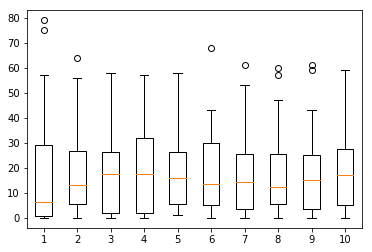

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure()
plt.boxplot(ensemble_confusion)
plt.show()

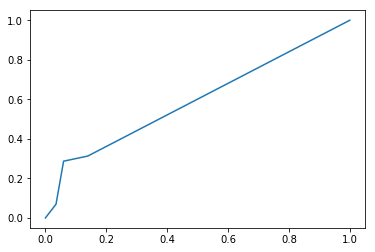

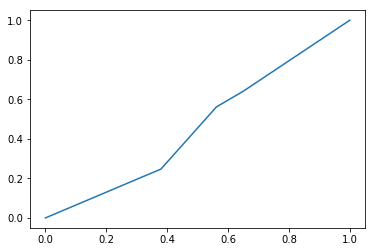

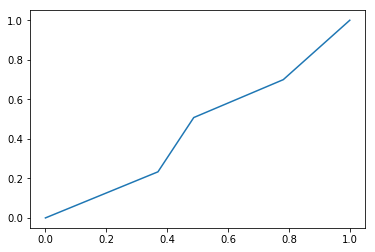

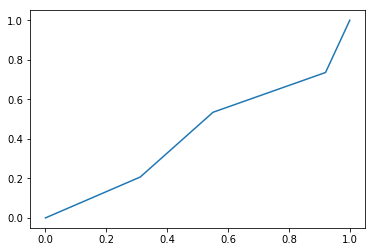

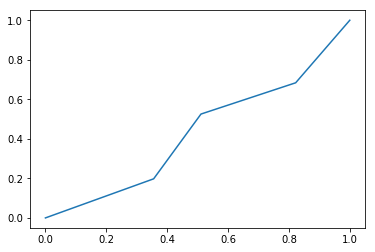

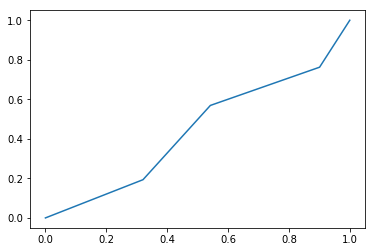

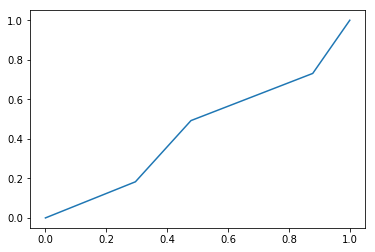

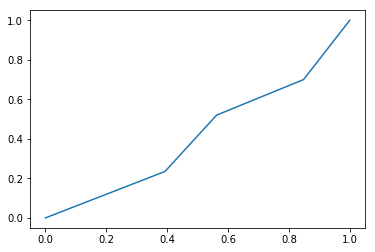

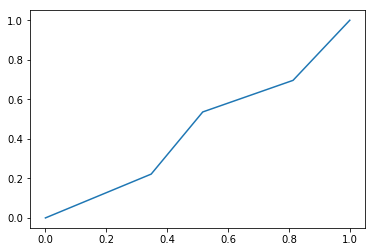

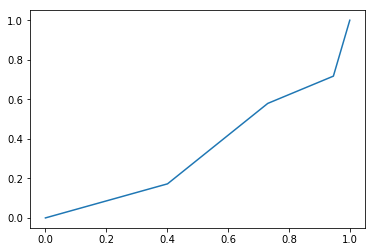

In [18]:
for x in roc:
    plt.figure()
    plt.plot(x[0], x[1])


In [19]:
auc_list

[0.59459225611075062,
 0.46075617157385385,
 0.44988461705925892,
 0.4247459603531567,
 0.42912743251726304,
 0.44169372864915024,
 0.43868903111895824,
 0.4135044642857143,
 0.4435173859863708,
 0.34439397067933097]

In [20]:
ensemble_confusion

[array([[79,  0,  0,  0],
        [75,  3,  1,  0],
        [41,  6, 25,  7],
        [57, 10,  4,  8]]), array([[64,  6,  3,  6],
        [35, 14,  5, 24],
        [ 1,  0, 56, 22],
        [12,  6, 17, 44]]), array([[58, 16,  2,  2],
        [20, 37,  2, 19],
        [ 2,  0, 53, 23],
        [ 4, 19, 10, 45]]), array([[46, 31,  1,  0],
        [ 9, 35,  8, 26],
        [ 2,  2, 57, 17],
        [ 0, 18, 24, 36]]), array([[56, 15,  1,  6],
        [18, 28,  7, 25],
        [ 2,  1, 58, 17],
        [ 4, 26, 13, 35]]), array([[43, 28,  0,  7],
        [10, 35,  6, 27],
        [ 0,  2, 68,  8],
        [ 3, 17, 23, 35]]), array([[53, 20,  0,  5],
        [12, 47,  3, 16],
        [ 0,  4, 61, 13],
        [ 2, 22, 18, 36]]), array([[60, 10,  2,  6],
        [14, 36,  6, 22],
        [ 0,  5, 57, 16],
        [ 3, 17, 11, 47]]), array([[59, 15,  0,  4],
        [19, 31,  5, 23],
        [ 1,  2, 61, 14],
        [ 2, 18, 15, 43]]), array([[41, 22,  0, 15],
        [ 6, 20, 17, 35],
   